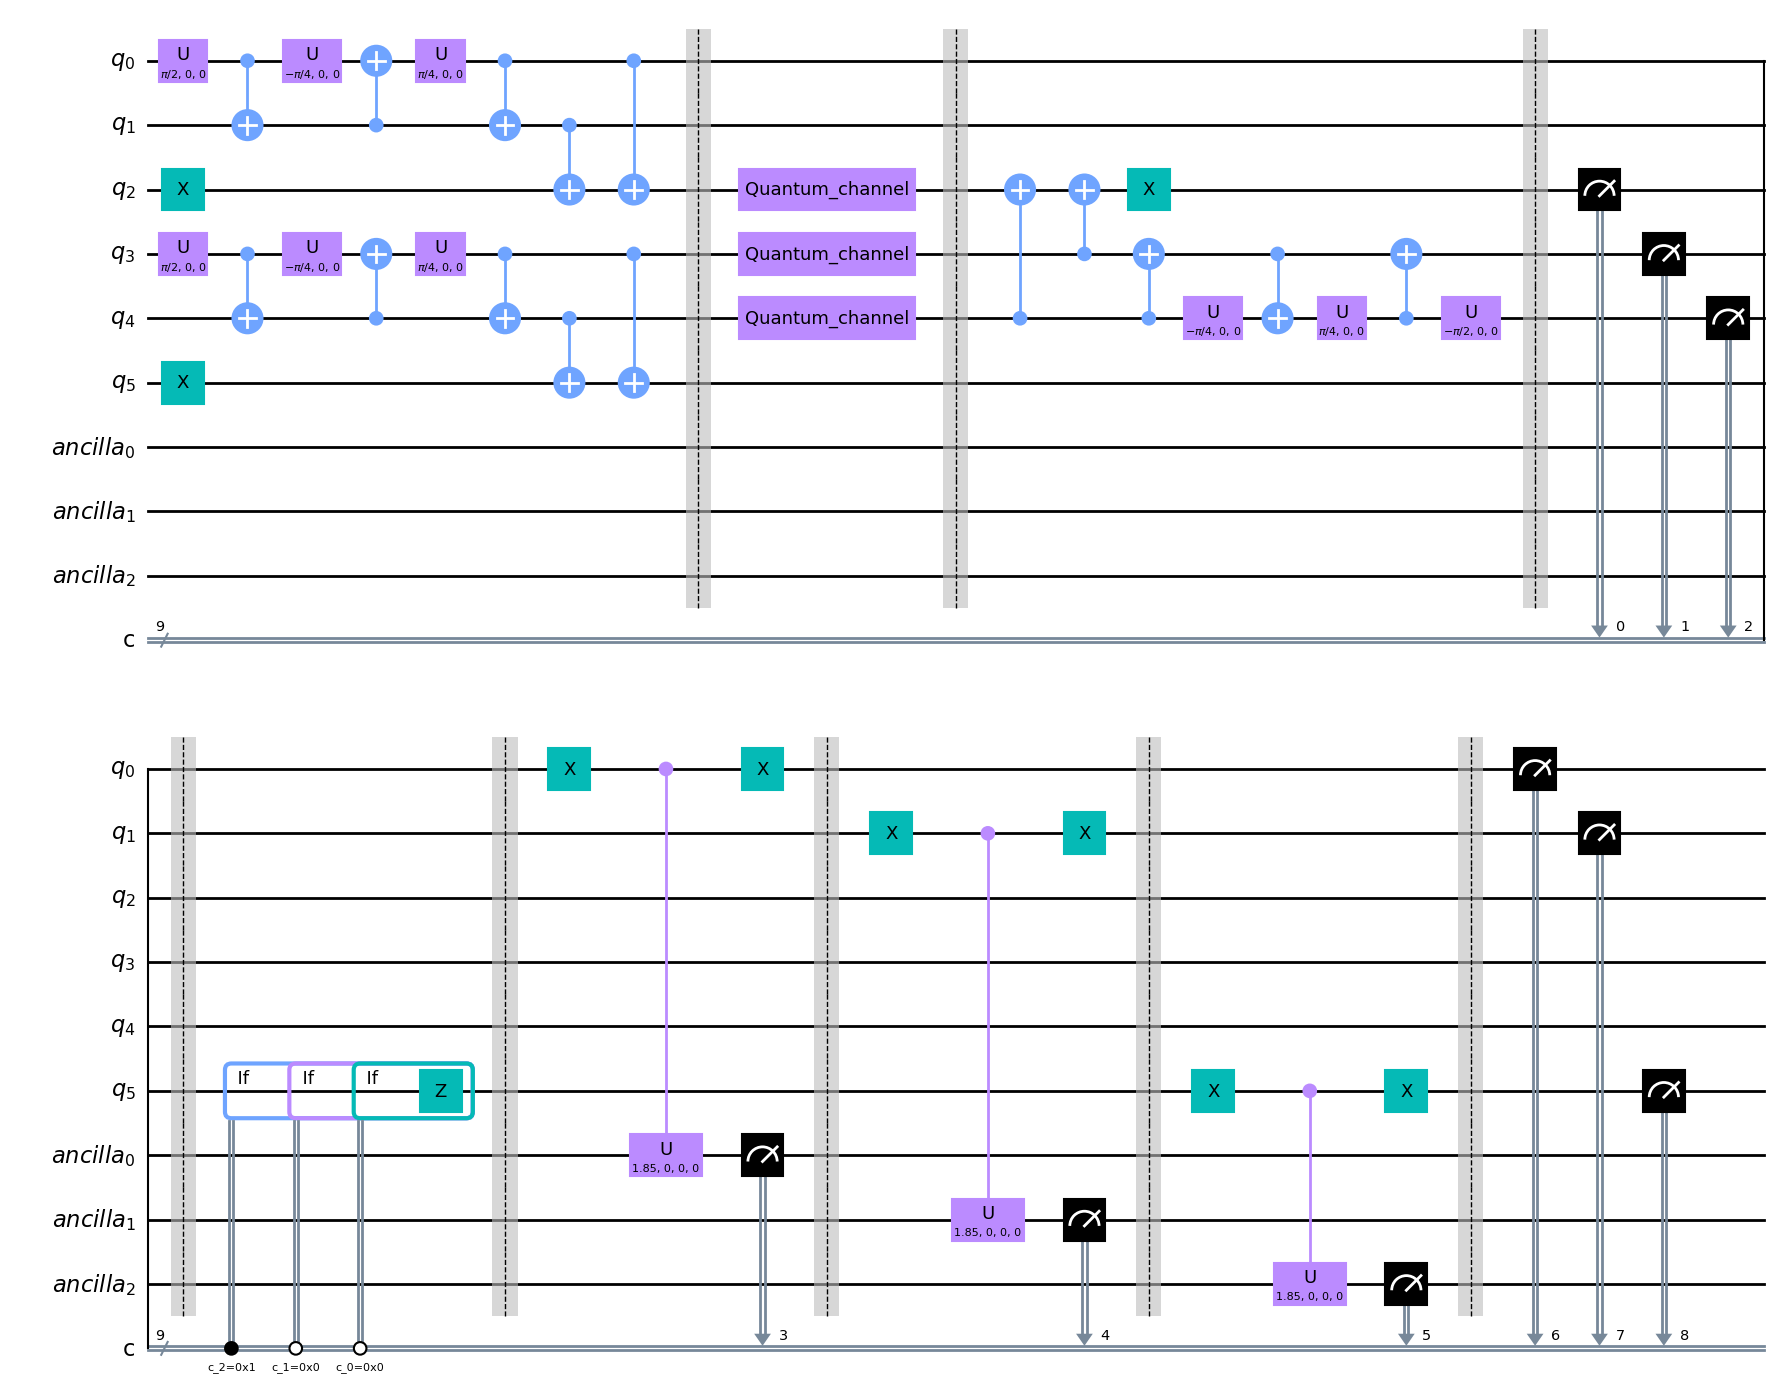

In [24]:
import numpy as np
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,transpile, assemble, execute, Aer
import matplotlib.pyplot as plt
import math
from math import pi
from qiskit.providers.aer.noise import amplitude_damping_error,NoiseModel, depolarizing_error, ReadoutError
from qiskit import QuantumCircuit, Aer, execute

q = QuantumRegister(6, 'q')
anc = QuantumRegister(3, 'ancilla')
c = ClassicalRegister(9, 'c')
circ = QuantumCircuit(q, anc, c)

# Preparation of the first W state:
circ.u(pi/2, 0,0, q[0])
circ.x(q[2])
circ.cx(q[0], q[1])
circ.u(-pi/4, 0,0, q[0])
circ.cx(q[1], q[0])
circ.u(pi/4, 0,0, q[0])
circ.cx(q[0], q[1])
circ.cx(q[1], q[2])
circ.cx(q[0], q[2])

# Preparation of the second W state:
circ.u(pi/2, 0,0, q[3])
circ.x(q[5])
circ.cx(q[3], q[4])
circ.u(-pi/4, 0,0, q[3])
circ.cx(q[4], q[3])
circ.u(pi/4, 0,0, q[3])
circ.cx(q[3], q[4])
circ.cx(q[4], q[5])
circ.cx(q[3], q[5])

circ.barrier()

# Sending qubits through amplitude damping channel to Charlie
r = 0.3
error = amplitude_damping_error(r, excited_state_population=0, canonical_kraus=True)
circ.append(error, [q[2]])
circ.append(error, [q[3]])
circ.append(error, [q[4]])
circ.barrier()

# Entanglement swapping process:
circ.cx(q[4], q[2])
circ.cx(q[3], q[2])
circ.cx(q[4], q[3])
circ.u(-pi/4,0,0, q[4])
circ.cx(q[3], q[4])
circ.u(pi/4, 0,0, q[4])
circ.cx(q[4], q[3])
circ.x(q[2])
circ.u(-pi/2, 0,0, q[4])

circ.barrier()

# Measuring qubits at Charlie's location:
circ.measure([2, 3, 4], [0, 1, 2])
circ.barrier()

# Employing corresponding operations according to the results of Charlie's measurement:
p=0.64
t=2*np.arctan((np.sqrt(p))/np.sqrt(1-p));

with circ.if_test((c[2], 1)):
    with circ.if_test((c[1], 0)):
        with circ.if_test((c[0], 0)):
            circ.z(q[5]) 
            
            #Employing meas
circ.barrier()
circ.x(q[0])
circ.cu(t, 0, 0, 0, q[0], anc[0])
circ.measure([anc[0]], [3])
circ.x(q[0])
circ.barrier()
circ.x(q[1])
circ.cu(t, 0, 0, 0, q[1], anc[1])
circ.measure([anc[1]], [4])
circ.x(q[1])
circ.barrier()
circ.x(q[5])
circ.cu(t, 0, 0, 0, q[5], anc[2])
circ.measure([anc[2]], [5])
circ.x(q[5])            

circ.barrier()
circ.measure([0,1,5], [6,7,8])
circ.draw('mpl')


In [25]:
circ=circ.reverse_bits ()
Shots_n=100000
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(circ, method=method, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result

counts = result.get_counts()  # Get the measurement counts
print(counts)

{'100000101': 2281, '001000010': 562, '101110000': 1030, '001010001': 2016, '101111000': 1927, '100000001': 507, '101000011': 2261, '101101000': 1054, '101101010': 760, '101010100': 441, '000011100': 1835, '001010000': 427, '101110001': 1546, '001110001': 3571, '100010000': 586, '100001100': 423, '000100010': 991, '000010001': 1988, '100110000': 1108, '101100011': 4048, '001001100': 969, '100100010': 453, '001100001': 2044, '000000010': 547, '001000100': 551, '100000011': 2301, '100010101': 3957, '001001010': 1039, '000001010': 955, '000100001': 1933, '000101010': 1790, '000000001': 1121, '100000000': 356, '100011100': 780, '101010101': 3928, '001111000': 1417, '101100001': 873, '001000001': 1148, '100010001': 867, '001110000': 786, '000001100': 1019, '100100001': 817, '001100010': 1018, '101010000': 629, '000010100': 986, '101011100': 742, '001101010': 1792, '001011000': 791, '100100011': 4076, '001100000': 458, '101001100': 467, '101000101': 2223, '100101000': 1018, '001011100': 1743

4972
probability of success 0.04972
fidelity 0.9001953915918933


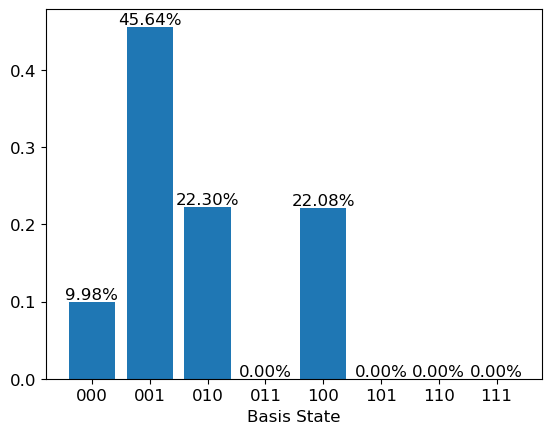

In [30]:
##############################################

success, fail = 0, 0
Bell_states = {}
Bell_new = {}

for jj in counts:  
    #if jj[0] == jj[1] == jj[2]=='0' and jj[3]==jj[4]==jj[5]=='0': #Results corresponidng to \eta+
    #if jj[0] == jj[1]=='0' and jj[2]=='1' and jj[3]==jj[4]==jj[5]=='0':  #Results corresponidng to \eta-
   
    if (jj[0] == jj[1] == jj[2]=='0' and jj[3]=='0' and jj[3]==jj[4]==jj[5]=='0') or (jj[0] == jj[1]=='0' and jj[2]=='1' and jj[3]==jj[4]==jj[5]=='0'): #Results for both \eta+ and \eta-
        success += counts[jj]
        Bell_state = jj
        if Bell_state in Bell_states:
            Bell_states[Bell_state] += counts[jj]
        else:
            Bell_states[Bell_state] = counts[jj]
    else:
        fail += counts[jj]

total = success + fail

# Extract the shared entangled qubits state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[6:]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]

print(success)
print('probability of success',success/total)

# Convert counts to a sorted list of probabilities
basis_states = ['000', '001', '010', '011', '100', '101', '110', '111']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states]

#Finding probabilites for fidelity:
s22 = probabilities[basis_states.index('001')]
s33 = probabilities[basis_states.index('010')]
s55 = probabilities[basis_states.index('100')]
s35=np.sqrt(s33)*np.sqrt(s55)
s23=np.sqrt(s22)*np.sqrt(s33)
s25=np.sqrt(s22)*np.sqrt(s55)
fidelity=s22/2 + s33/4 + s35/2 + s55/4 + (np.sqrt(2)*s23)/2 + (np.sqrt(2)*s25)/2
print('fidelity=',fidelity)


# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State', fontsize=12)

# Add percentage labels on top of each bar
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom',  fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()